In [35]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

500 images / 7 types / in RGB format / 768x568 resolution
* 50 columnar epithelial cells 
* 50 parabasal squamous epithelial cells 
* 50 intermediate squamous epithelial cells 
* 50 superficial squamous epithelial cells 
* 100 mild nonkeratinizing dysplastic cells 
* 100 moderate nonkeratinizing dysplastic cells 
* 100 severe nonkeratinizing dysplastic cells 

General framework for processing images in a batch setting

In [3]:
inter36 = "Cancerous cell smears/inter36.BMP"

In [60]:
# def batch_process(folder, *funcs): can try this after one function test
    # files = glob.glob(f"{folder}/*")
    # for file in files:
def single_process(file):
    
    img = Image.open(file)
    width, height = img.size
    pix = img.getdata()
    pix_list = []
    for y in range(height):
        pix_list.append([pix[y * width + x] for x in range(width)])

    # all functions are on grayscale, so this step is required
    pix_list = grayscale(pix_list)

    # for func in funcs:
    #     pix_list = func(pix_list)

    # pix_list = frequency_capper(pix_list, 155)
    bins, counts = hist(pix_list, 255)

    flat_list = []
    for row in pix_list:
        for pixel in row:
            flat_list.append(pixel)
    output = Image.new("L", img.size)
    output.putdata(flat_list)
    
    # output.save(f"output/{file}")
    return output
      

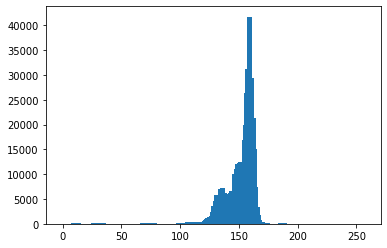

In [61]:
output = single_process(inter36)
# output

Noise addition functions: 
* Salt and pepper noise of user-specified strength 
* Gaussian noise of user-specified parameters

Converting color images to selected single color spectrum. 

In [16]:
def grayscale(img):
    new_img = img
    for i in range(len(img)):
        for j in range(len(img[i])):
            # CIE recommended constants
            grey = .2126 * img[i][j][0] + .7152 * img[i][j][1]+ .0722 * img[i][j][2]
            new_img[i][j] = grey
    return new_img

Histogram calculation for each individual image

In [62]:
def hist(img, bins = 255, plot = False):
    bin_divs = []
    counts = []
    for i in range(1, bins + 1):
        bin_divs.append(i * 255/bins)
        counts.append(0)

    for i in range(len(img)):
        for j in range(len(img[i])):
            # better as a binary search
            for k in range(bins):
                if img[i][j] <= bin_divs[k]:
                    counts[k] += 1
                    break
    
    if plot:
        plt.bar(bin_divs, counts, width = 1)

    return bins, counts

Averaged histograms of pixel values for each class of images

Histogram equalization for each image

Selected image quantization technique for user-specified levels


In [19]:
def frequency_capper(img, max_freq):
    new_img = img
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] > max_freq:
                new_img[i][j] = max_freq
    return new_img

Filtering operations: 
*Linear filter with user-specified mask size and pixel weights
*Median filter with user-specified mask size and pixel weights


Display the following performance measures:
* Processing time for the entire batch per each procedure 
* Averaged processing time per image per each procedure 
* MSQE for image quantization levels 